In [2]:
import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from torchvision import models, transforms
from utils import ImageDataset, SaveFeatures, accuracy, imshow_transform
from VGG_model import vgg19
from torch.autograd import Variable


#####################
# Define dataloaders
#####################


# image_dir = "/home/nadjaflechner/Palsa_data/dataset_100m/"
# labels_file = "/home/nadjaflechner/Palsa_data/binary_palsa_labels_100m.csv"

image_dir = "/Users/nadja/Documents/UU/Thesis/Data/100m"
labels_file = "/Users/nadja/Documents/UU/Thesis/Data/100m_palsa_labels.csv"

# Load the labels from the CSV file
labels_df = pd.read_csv(labels_file, index_col=0).head(100)

# Split the dataset into training and validation sets
train_df = labels_df.head(80)
val_df = labels_df.drop(train_df.index)

# Create the datasets and data loaders
train_dataset = ImageDataset(image_dir, train_df )
val_dataset = ImageDataset(image_dir, val_df )
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=40, shuffle=True)

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F75BB06B-2723-344D-99CE-9CB8BB94077A> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
###############
# Define model
###############

model = vgg19()

#freeze layers
for idx, param in enumerate(model.parameters()):
    if idx == 30:
        break
    param.requires_grad = False

#modify the last two convolutions
model.features[-5] = nn.Conv2d(512,512,3, padding=1)
model.features[-3] = nn.Conv2d(512,2,3, padding=1)

#remove fully connected layer and replace it with AdaptiveAvePooling
model.classifier = nn.Sequential(
                                nn.AdaptiveAvgPool2d(1),
                                nn.Flatten(),
                                nn.LogSoftmax()
                                )

In [5]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()
num_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define weights information 
weights = models.VGG19_Weights.DEFAULT
transforms = weights.transforms()

for epoch in range(num_epochs):

    train_acc = []
    val_acc = []
        
    model.train()
    count = 0
    for batch_idx, (images, labels) in enumerate(train_loader):        
        images = Variable(transforms(images)).to(device)
        labels = Variable(labels.long()).to(device)
        
        outputs = model(images) 
        print(outputs)
        
        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        train_acc.append(accuracy(outputs, labels))
        
        loss.backward()
        optimizer.step()  

        if batch_idx == 10:
            break  
        
    

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*a

tensor([[-1.0486e+01, -2.7895e-05],
        [-1.2431e+01, -3.9339e-06]], grad_fn=<LogSoftmaxBackward0>)
tensor([[  0.0000, -20.5919],
        [  0.0000, -19.9871]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.5384e-03, -5.9775e+00],
        [-3.4575e-03, -5.6689e+00]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-0.3781, -1.1557],
        [-0.3376, -1.2499]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-0.5381, -0.8767],
        [-0.5553, -0.8531]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-0.6543, -0.7335],
        [-0.5580, -0.8495]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-0.6563, -0.7314],
        [-0.6186, -0.7737]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-0.6721, -0.7146],
        [-0.6916, -0.6947]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-0.6931, -0.6931],
        [-0.6839, -0.7025]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-0.6431, -0.7459],
        [-0.6874, -0.6989]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-0.6931, -0.6931],
        [-0.5953, -0.8017]], grad_fn=<LogSoftmaxBackward

In [7]:
model.eval()
count = 0
val_running_loss = 0.0
for batch_idx, (images, labels) in enumerate(val_loader):        
    images = Variable(transforms(images))
    labels = Variable(labels.long())
    
    outputs = model(images)
    loss = loss_function(outputs, labels)

    val_acc.append(accuracy(outputs, labels))

    if batch_idx == 4:
        break

print('Training accuracy:...', np.mean(train_acc))
print('Validation accuracy..', np.mean(val_acc))

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*a

Training accuracy:... 0.5
Validation accuracy.. 0.0


In [8]:
outputs

tensor([[-0.6856, -0.7007],
        [-0.6931, -0.6931]], grad_fn=<LogSoftmaxBackward0>)

#### THIS TRAINING LOOP BELOW RUNS, BUT OUTPUTS ARE IDENTICAL FOR ALL IMAGES FOR ALL CLASSES..


In [38]:
######################
# Define training loop
######################

# define model training parameters
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()
num_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define weights information 
weights = models.VGG19_Weights.DEFAULT
transforms = weights.transforms()

# Finetuning loop
for epoch in range(num_epochs):

    train_acc = []
    val_acc = []

    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        transformed_batch = transforms(data)

        optimizer.zero_grad()
        
        outputs = model(transformed_batch)
        print(outputs)
        loss = loss_function(outputs, targets.long())
        train_acc.append(accuracy(outputs, targets.long()))

        loss.backward()
        optimizer.step()

        print(f"batch {batch_idx} has been trained.")

        if batch_idx == 10:
            break 


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*a

tensor([[-4.6492e-06, -1.2277e+01],
        [-3.4809e-05, -1.0266e+01]], grad_fn=<LogSoftmaxBackward0>)
batch 0 has been trained.
tensor([[  0.0000, -56.2124],
        [  0.0000, -64.9888]], grad_fn=<LogSoftmaxBackward0>)
batch 1 has been trained.
tensor([[ 0.0000e+00, -1.7727e+01],
        [-2.1458e-06, -1.3079e+01]], grad_fn=<LogSoftmaxBackward0>)
batch 2 has been trained.
tensor([[-0.6846, -0.7018],
        [-0.6931, -0.6931]], grad_fn=<LogSoftmaxBackward0>)
batch 3 has been trained.
tensor([[-0.6931, -0.6931],
        [-0.6931, -0.6931]], grad_fn=<LogSoftmaxBackward0>)
batch 4 has been trained.
tensor([[-0.6931, -0.6931],
        [-0.6931, -0.6931]], grad_fn=<LogSoftmaxBackward0>)
batch 5 has been trained.
tensor([[-0.6931, -0.6931],
        [-0.6931, -0.6931]], grad_fn=<LogSoftmaxBackward0>)
batch 6 has been trained.
tensor([[-0.6931, -0.6931],
        [-0.6931, -0.6931]], grad_fn=<LogSoftmaxBackward0>)
batch 7 has been trained.
tensor([[-0.6931, -0.6931],
        [-0.7491, -0.640

In [20]:
transformed_batch

tensor([[[[365.7380, 404.7867, 410.8636,  ..., 198.4825, 181.4247, 176.1751],
          [339.8197, 379.0304, 388.6787,  ..., 208.7172, 191.6594, 179.0089],
          [340.8858, 354.5630, 361.5461,  ..., 218.9520, 201.8941, 185.0857],
          ...,
          [400.5254, 416.1494, 417.4287,  ..., 443.6871, 446.7789, 442.7607],
          [390.4506, 400.3708, 422.9725,  ..., 446.7789, 444.5400, 449.7437],
          [379.7937, 384.5092, 415.9596,  ..., 468.1236, 454.3174, 446.2906]],

         [[435.4686, 476.9191, 485.2570,  ..., 260.2748, 245.7245, 244.7763],
          [406.2469, 448.7176, 459.1808,  ..., 275.8323, 255.5054, 246.9103],
          [402.4868, 417.3281, 427.7913,  ..., 286.4589, 268.8568, 254.4852],
          ...,
          [460.3644, 478.9660, 480.4374,  ..., 462.4494, 465.7737, 461.7018],
          [448.7024, 459.9470, 485.9414,  ..., 462.2859, 462.8854, 468.8407],
          [435.8501, 443.0959, 478.7360,  ..., 480.6553, 470.0287, 465.9055]],

         [[374.9197, 417.2440,

In [ ]:
    model.eval()
    for batch_idx, (data, targets) in enumerate(val_loader):
        data, targets = data.to(device), targets.to(device)
        transformed_batch = transforms(data)
        outputs = model(transformed_batch)
        val_acc.append(accuracy(outputs, targets.long()))

        if batch_idx == 2:
            break 
        
    print('Training accuracy:...', np.mean(train_acc))
    print('Validation accuracy..', np.mean(val_acc))

In [17]:
outputs

tensor([[-0.6931, -0.6931],
        [-0.6931, -0.6931]], grad_fn=<LogSoftmaxBackward0>)

### Below is simply copied from CAM github 

https://github.com/tony-mtz/CAM/blob/master/CAM.ipynb

In [6]:

from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
from skimage.io import imshow

#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

#get the last convolution
sf = SaveFeatures(model.features[-3])

#get image and label
im, lab = next(iter(valid_loader))
# print(im.shape)

# im = Variable(im.cuda())
# lab = Variable(lab.cuda())
im = Variable(im)
lab = Variable(lab)
outputs = model(im)

#[ant, bee]
# res = torch.argmax(outputs.data).cpu().detach().numpy()
res = torch.argmax(outputs.data).numpy()


if res==1:
    print('result: palsa',res)
else:
    print('result: no palsa',res)

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F75BB06B-2723-344D-99CE-9CB8BB94077A> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


result: no palsa 0


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


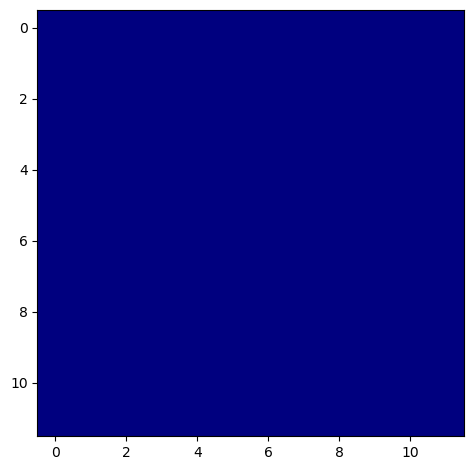

In [7]:
sf.remove()
arr = sf.features.cpu().detach().numpy()
arr1 = arr[0]
ans_ant = np.dot(np.rollaxis(arr1,0,3), [1,0])
ans_bee = np.dot(np.rollaxis(arr1,0,3), [0,1])
#ant activation
imshow(ans_ant, cmap='jet')

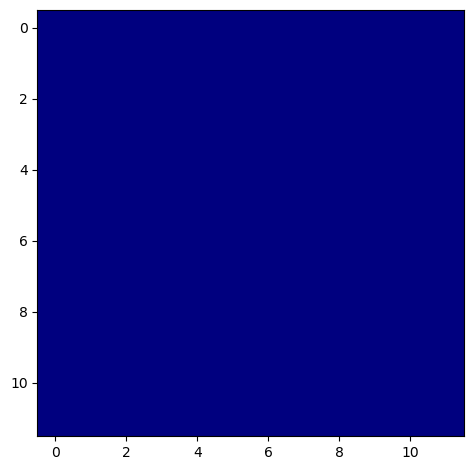

In [8]:
imshow(ans_bee, cmap='jet')


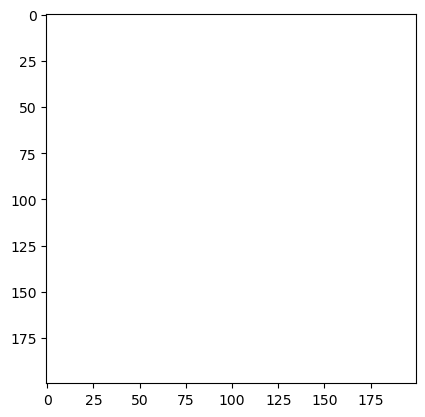

In [9]:
bee_ant = imshow_transform(im)


<Figure size 640x480 with 0 Axes>

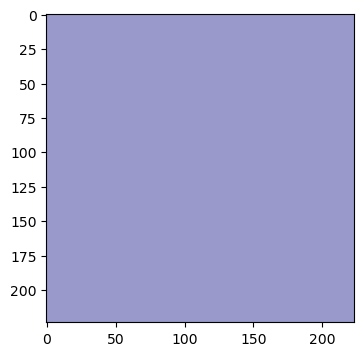

In [10]:
from skimage.transform import resize
bee_cam = resize(ans_bee, (224,224))

plt.figure()
plt.subplots(figsize=(4,4))
plt.imshow(bee_ant)
plt.imshow(bee_cam, alpha=.4, cmap='jet')
plt.show()